# Facial Keypoint Detection

### 1) Setup and loading data 

The first few cells are concerned with loading libraries, data sets, and setting up train/dev/test sets


In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics
from scipy.spatial import distance

import csv



In [2]:
data_directory = '../data/'
training_csv = 'training.csv'
test_csv = 'test.csv'

def space_separated_string_to_numpy_array(string):
    return np.fromstring(string, dtype=int, sep=" ")

def read_data_as_data_frame_with_image_array(data_directory, csv):
    return pd.read_csv(data_directory + csv, converters = { 
        'Image' : space_separated_string_to_numpy_array
    })

training_and_development_df = read_data_as_data_frame_with_image_array(data_directory, training_csv)
test_df = read_data_as_data_frame_with_image_array(data_directory, test_csv)
test_data = np.array(test_df['Image'])
test_image_ids = np.array(test_df['ImageId'])

# The training_shuffle is used to randomly (but the same way every time) to split the data into
# training data and development data
# Set the randomizer seed so results are the same each time.
np.random.seed(0)
training_shuffle = np.random.permutation(len(training_and_development_df.index))

In [38]:
training_df = training_and_development_df[len(test_df.index):]
development_df = training_and_development_df[:len(test_df.index)]

training_df_columns = training_df.columns.values
training_df_training_columns = np.asarray([ 'Image' ])
training_df_label_columns = training_df_columns[np.where(training_df_columns != 'Image')]
def training_label_to_index(label):
    return np.where(training_df_label_columns == label)[0]
    
def index_to_training_label(index):
    return training_df_label_columns[index]

training_data = np.array(training_df['Image'])
training_labels = np.array(training_df[training_df_label_columns])
development_data = np.array(development_df['Image'])
development_labels = np.array(development_df[training_df_label_columns])
label_names = training_df_label_columns
x_label_indices = [ index for index, name in enumerate(label_names) if '_x' in name ]
y_label_indices = [ index for index, name in enumerate(label_names) if '_y' in name ]





## 2) A way to look at the data 

Showing an example, plotting but the labels/correct answers and predictions

In [112]:
def show_one_example(example, labels = None, predictions = None):
    matrix = np.reshape(255 - example, (96, 96))
    plt.imshow(matrix, cmap='Greys', interpolation='Nearest')
    if labels is not None:
        x_labels = labels[x_label_indices]
        y_labels = labels[y_label_indices]
        plt.scatter(x_labels, y_labels, c='g', marker = 'o')
    if predictions is not None:
        x_predictions = predictions[x_label_indices]
        y_predictions = predictions[y_label_indices]
        plt.scatter(x_predictions, y_predictions, c='r', marker='x')
    plt.tight_layout()
    plt.show()

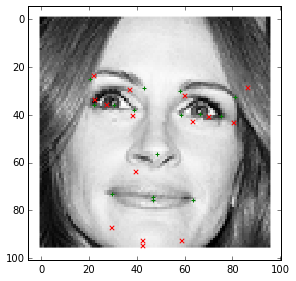

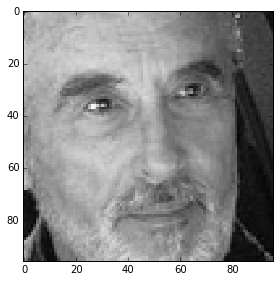

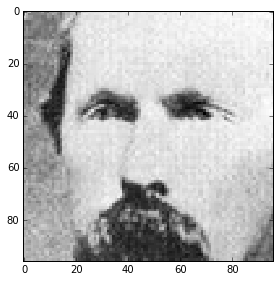

In [92]:
# intentially using the wrong predictions to show labels (green +) vs predictions (red x)

show_one_example(training_data[0], training_labels[0], training_labels[1])
show_one_example(training_data[100])
show_one_example(training_data[1000])

## 3) Computing of the error (we use pixel RMSE)

Some functions for overall fitness scoring (`development_score`) as well as for looking for errors

In [101]:
def compute_example_squared_errors(example_predicted, example_labels):
    return [ 
        (example_predicted[index] - label) ** 2
        for index, label 
        in enumerate(example_labels) 
    ]

def compute_error_squared_matrix(all_examples_predicted, all_examples_labels):
    return [
        compute_example_squared_errors(example_predicted, all_examples_labels[index])
        for index, example_predicted
        in enumerate(all_examples_predicted)
    ]

def rmse(error_matrix):
    return np.sqrt(np.nanmean(error_matrix))

def development_score(development_predictions):
    error_matrix = np.matrix(
        compute_error_squared_matrix(development_predictions, development_labels)
    )
    
    return rmse(error_matrix)

## 4) Establishing a baseline (simple mean of training algorithm)

*** Baseline development data score: 3.76889949349
*** Reference (R implementation score, some randomness): 3.758999
*** Baseline (mean coordinate) predictions on first example


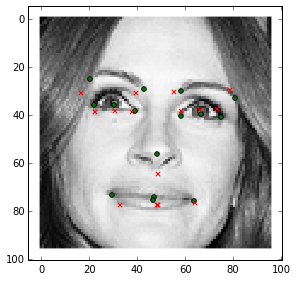

In [114]:

# Baseline - predict the mean keypoints for the training set
baseline_mean_predictions = {
        name: np.mean(
            [ 
                training_label[index] 
                for training_label 
                in training_labels 
                if training_label[index] >= 0.0
            ]
        )
        for index, name

        in enumerate(label_names)
    }

baseline_mean_predictions_array = np.array([ baseline_mean_predictions[name] for name in label_names ])

def baseline_mean_predict(example):
    return baseline_mean_predictions_array   

def baseline():
    baseline_development_predictions = [ 
        baseline_mean_predict(example) 
        for example 
        in development_data 
    ]
    
    baseline_development_score = development_score(baseline_development_predictions)
    print('*** Baseline development data score: ' + str(baseline_development_score))
    
    print('*** Reference (R implementation score, some randomness): 3.758999') 
    print('*** Baseline (mean coordinate) predictions on first example')
    
    show_one_example(training_data[0], training_labels[0], baseline_mean_predict(training_data[0]))
                     
baseline()